# 配当利回り

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/J-Quants/jquants-api-client-python/blob/master/examples/20220825-003-dividend.ipynb)


このノートブックでは J-Quants APIから取得できるデータから配当性向、配当利回り、および直近1,3ヶ月のリターンを一覧で表示します。


----

**このノートブックはGoogle Driveを使用します。**

- Google Drive の以下のファイルにリフレッシュトークンが書き込まれていることを想定しています。
    - `MyDrive/drive_ws/secret/jquantsapi-key.txt`
- Google Drive の以下のフォルダーにデータを書き込みます。
    - `MyDrive/drive_ws/marketdata`

In [1]:
# python version　3｡10｡9で動作確認
!python --version

Python 3.10.9


In [2]:
# 必要なモジュールをインストールします。
! python -m pip install jquants-api-client japanize-matplotlib

In [3]:
import os
from datetime import datetime

import japanize_matplotlib
import jquantsapi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
# pandas の表示制限を調整します
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
pd.set_option("display.width", 2000)

In [5]:
# プロット用の設定をします
sns.set(rc={'figure.figsize': (15, 10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

japanize_matplotlib.japanize()

In [6]:
# 一度取得したデータは Google Drive 上に保存して再利用します。
# 保存先ディレクトリを指定します。
STORAGE_DIR_PATH = "../drive_ws/marketdata"
os.makedirs(STORAGE_DIR_PATH, exist_ok=True)
STORAGE_DIR_PATH

'../drive_ws/marketdata'

In [7]:
# J-Quants APIのトークンを保存してあるファイルを指定します
REFRESH_TOKEN_FILE_PATH = "../drive_ws/secret/jquantsapi-key.txt"

In [8]:
def get_refresh_token(refresh_token_file_path: str = REFRESH_TOKEN_FILE_PATH):
    with open(refresh_token_file_path, "r") as f:
        refresh_token = f.read()
    return refresh_token.rstrip().lstrip()

In [9]:
# ファイルからリフレッシュトークンを読み込みます
refresh_token = get_refresh_token()


In [10]:
# J-Quants APIクライアントを初期化します
jqapi = jquantsapi.Client(refresh_token=refresh_token)

In [11]:
# 銘柄情報を取得します
## 原罪時間を取り込み
now = pd.Timestamp.now(tz="Asia/Tokyo")
## 時間が22時より前
if now.hour < 22:
    # データ更新時間前の場合は日付を1日ずらします。
    now -= pd.Timedelta(1, unit="D")

list_file = f"{STORAGE_DIR_PATH}/list_{now.strftime('%Y%m%d')}.csv.gz"
if not os.path.isfile(list_file):
    df_list = jqapi.get_list()
    df_list.to_csv(list_file, compression="gzip", index=False)
    print(f"save file: {list_file}")

# ファイルからデータを読み込みます
print(f"file exists: {list_file}, loading")
df_list = pd.read_csv(list_file, dtype="str")
df_list

file exists: ../drive_ws/marketdata/list_20230128.csv.gz, loading


,Date,Code,CompanyName,Sector17Code,Sector17CodeName,Sector33Code,Sector33CodeName,ScaleCategory,MarketCode,MarketCodeName,Sector17CodeNameEnglish,Sector33CodeNameEnglish,MarketCodeNameEnglish
0,2023-01-30,13010,極洋,1,食品,0050,水産・農林業,TOPIX Small 2,111,プライム,FOODS,"Fishery, Agriculture & Forestry",Prime
1,2023-01-30,13050,ダイワ上場投信−トピックス,99,その他,9999,その他,-,109,その他,OTHER,Other,Others
2,2023-01-30,13060,ＮＥＸＴＦＵＮＤＳＴＯＰＩＸ連動型上場投信,99,その他,9999,その他,-,109,その他,OTHER,Other,Others
3,2023-01-30,13080,上場インデックスファンドＴＯＰＩＸ,99,その他,9999,その他,-,109,その他,OTHER,Other,Others
4,2023-01-30,13090,ＮＥＸＴＦＵＮＤＳＣｈｉｎａＡＭＣ・中国株式・上証５０連動型上場投信,99,その他,9999,その他,-,109,その他,OTHER,Other,Others
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4242,2023-01-30,99930,ヤマザワ,14,小売,6100,小売業,TOPIX Small 2,112,スタンダード,RETAIL TRADE,Retail Trade,Standard
4243,2023-01-30,99940,やまや,14,小売,6100,小売業,TOPIX Small 2,112,スタンダード,RETAIL TRADE,Retail Trade,Standard
4244,2023-01-30,99950,グローセル,13,商社・卸売,6050,卸売業,TOPIX Small 2,111,プライム,COMMERCIAL & WHOLESALE TRADE,Wholesale Trade,Prime
4245,2023-01-30,99960,サトー商会,13,商社・卸売,6050,卸売業,-,112,スタンダード,COMMERCIAL & WHOLESALE TRADE,Wholesale Trade,Standard


##　株価情報の取得

In [12]:
# 株価情報を取得します
now = pd.Timestamp.now(tz="Asia/Tokyo")
# 過去3ヶ月のデータを取得
start_dt = now - pd.Timedelta(95, unit="D")
end_dt = now
if end_dt.hour < 19:
    # データ更新時間前の場合は日付を1日ずらします。
    end_dt -= pd.Timedelta(1, unit="D")
    
price_file = f"{STORAGE_DIR_PATH}/price_{start_dt.strftime('%Y%m%d')}_{end_dt.strftime('%Y%m%d')}.csv.gz"
if not os.path.isfile(price_file):
    df_p = jqapi.get_price_range(start_dt=start_dt, end_dt=end_dt)
    df_p.to_csv(price_file, compression="gzip", index=False)
    df_p.reset_index(drop=True, inplace=True)
    print(f"save file: {price_file}")

# データを読み込みます
print(f"file exists: {price_file}, loading")
df_p = pd.read_csv(price_file, dtype="str")
df_p.reset_index(drop=True, inplace=True)

# 各列のデータ型を調整します
df_p.loc[:, "Date"] = pd.to_datetime(df_p["Date"], format="%Y-%m-%d")
df_p.loc[:, "Open"] = df_p["Open"].astype(np.float64)
df_p.loc[:, "High"] = df_p["High"].astype(np.float64)
df_p.loc[:, "Low"] = df_p["Low"].astype(np.float64)
df_p.loc[:, "Close"] = df_p["Close"].astype(np.float64)
df_p.loc[:, "Volume"] = df_p["Volume"].astype(np.float64)
df_p.loc[:, "TurnoverValue"] = df_p["TurnoverValue"].astype(np.float64)
df_p.loc[:, "AdjustmentFactor"] = df_p["AdjustmentFactor"].astype(np.float64)
df_p.loc[:, "AdjustmentOpen"] = df_p["AdjustmentOpen"].astype(np.float64)
df_p.loc[:, "AdjustmentHigh"] = df_p["AdjustmentHigh"].astype(np.float64)
df_p.loc[:, "AdjustmentLow"] = df_p["AdjustmentLow"].astype(np.float64)
df_p.loc[:, "AdjustmentClose"] = df_p["AdjustmentClose"].astype(np.float64)
df_p.loc[:, "AdjustmentVolume"] = df_p["AdjustmentVolume"].astype(np.float64)

file exists: ../drive_ws/marketdata/price_20221026_20230128.csv.gz, loading


/var/folders/kx/n6w_n8193fn6dy4jwf3fsr6w0000gn/T/ipykernel_8313/2407126456.py:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_p.loc[:, "Date"] = pd.to_datetime(df_p["Date"], format="%Y-%m-%d")
/var/folders/kx/n6w_n8193fn6dy4jwf3fsr6w0000gn/T/ipykernel_8313/2407126456.py:24: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_p.loc[:, "Open"] = df_p["Open"].astype(np.float64)
/var/folders/kx/n6w_n8193fn6dy4jwf3fsr6w0000gn/T/ipykernel_8313/2407126456.py:25: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to s

## 財務情報の取得

In [13]:
# 過去3ヶ月に発表された財務情報を取得します

# 取得する日時設定
now = pd.Timestamp.now(tz="Asia/Tokyo")
start_dt = now - pd.Timedelta(90, unit="D")
end_dt = now
if end_dt.hour < 1:
    # データ更新時間前の場合は日付を1日ずらします。
    end_dt -= pd.Timedelta(1, unit="D")

# ファイル名を決める。既に取得したデータがあればそのデータを使う。
statements_file = f"{STORAGE_DIR_PATH}/statements_{start_dt.strftime('%Y%m%d')}_{end_dt.strftime('%Y%m%d')}.csv.gz"
if not os.path.isfile(statements_file):
    cache_dir = f"{STORAGE_DIR_PATH}/raw_statements"
    os.makedirs(cache_dir, exist_ok=True)
    df_s = jqapi.get_statements_range(
        start_dt=start_dt, end_dt=end_dt, cache_dir=cache_dir
    )
    df_s.to_csv(statements_file, compression="gzip", index=False)
    print(f"save file: {statements_file}")

print(f"file exists: {statements_file}, loading")
df_s = pd.read_csv(statements_file, dtype="str")
# float64にするために"-"をnp.nanに置き換えます
df_s.replace({"－": np.nan}, inplace=True)
df_s["ResultDividendPerShareFiscalYearEnd"] = df_s["ResultDividendPerShareFiscalYearEnd"].astype(np.float64)
df_s["EarningsPerShare"] = df_s["EarningsPerShare"].astype(np.float64)
df_s["ForecastDividendPerShareAnnual"] = df_s["ForecastDividendPerShareAnnual"].astype(np.float64)
df_s["ForecastEarningsPerShare"] = df_s["ForecastEarningsPerShare"].astype(np.float64)
# 日付型に変換します
df_s.loc[:, "DisclosedDate"] = pd.to_datetime(
    df_s["DisclosedDate"], format="%Y-%m-%d"
)
df_s.loc[:, "CurrentPeriodEndDate"] = pd.to_datetime(
    df_s["CurrentPeriodEndDate"], format="%Y-%m-%d"
)
df_s.loc[:, "CurrentFiscalYearStartDate"] = pd.to_datetime(
    df_s["CurrentFiscalYearStartDate"], format="%Y-%m-%d"
)
df_s.loc[:, "CurrentFiscalYearEndDate"] = pd.to_datetime(
    df_s["CurrentFiscalYearEndDate"], format="%Y-%m-%d"
)
df_s.sort_values("DisclosedUnixTime", inplace=True)

file exists: ../drive_ws/marketdata/statements_20221031_20230129.csv.gz, loading


/var/folders/kx/n6w_n8193fn6dy4jwf3fsr6w0000gn/T/ipykernel_8313/2588838669.py:31: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_s.loc[:, "DisclosedDate"] = pd.to_datetime(
/var/folders/kx/n6w_n8193fn6dy4jwf3fsr6w0000gn/T/ipykernel_8313/2588838669.py:34: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_s.loc[:, "CurrentPeriodEndDate"] = pd.to_datetime(
/var/folders/kx/n6w_n8193fn6dy4jwf3fsr6w0000gn/T/ipykernel_8313/2588838669.py:37: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace i

## 株価データを作業ワークへ
財務情報　：　df_work = df_s.copy()
株価情報　：　df_p_work = df_p.copy()

In [14]:
# 作業用にデータをコピーします
df_work = df_s.copy()
df_p_work = df_p.copy()

## 前処理

In [15]:
# 財務情報を銘柄ごとに重複を排除して最新の財務情報のみを使用します
df_work.sort_values("DisclosedUnixTime", inplace=True)
df_work = df_work.drop_duplicates(["LocalCode"], keep="last")

# 終値が0の場合は前営業日の終値を使用します
df_p_work.sort_values(["Code", "Date"], inplace=True)
df_p_work["AdjustmentClose"].replace({0.0: np.nan}, inplace=True)
df_p_work.loc[:, "AdjustmentClose"] = df_p_work.groupby("Code")["AdjustmentClose"].ffill()
# 終値がnanの場合は翌営業日の終値を使用します (データの先頭)
df_p_work.loc[:, "AdjustmentClose"] = df_p_work.groupby("Code")["AdjustmentClose"].bfill()
# 各銘柄の直近のリターンを算出します
def _calc_return(df, bdays):
  return (df["AdjustmentClose"].iat[-1] / df["AdjustmentClose"].iloc[-bdays:].iat[0]) - 1
df_p_work.sort_values(["Code", "Date"], inplace=True)
df_returns_1months = df_p_work.groupby("Code").apply(_calc_return, 20).rename("1ヶ月リターン")
df_returns_3months = df_p_work.groupby("Code").apply(_calc_return, 60).rename("3ヶ月リターン")
# リターンと結合します
df_work = pd.merge(df_work, df_returns_1months, left_on=["LocalCode"], right_index=True, how="left")
df_work = pd.merge(df_work, df_returns_3months, left_on=["LocalCode"], right_index=True, how="left")

# 配当利回りを計算するために直近の終値を取得します
df_close = df_p_work.loc[df_p_work["Date"] == df_p_work["Date"].max(), ["Code", "Date", "AdjustmentClose"]]
# 直近の株価と結合します
df_work = pd.merge(df_work, df_close, left_on=["LocalCode"], right_on=["Code"], how="left")
# 配当利回りを算出します
df_work["配当利回り"] = df_work["ResultDividendPerShareFiscalYearEnd"] / df_work["AdjustmentClose"]
# 予想配当利回りを算出します
df_work["予想配当利回り"] = df_work["ForecastDividendPerShareAnnual"] / df_work["AdjustmentClose"]

# 配当性向を算出します
df_work["配当性向"] = df_work["ResultDividendPerShareFiscalYearEnd"] / df_work["EarningsPerShare"] 
# 予想配当性向を算出します
df_work["予想配当性向"] = df_work["ForecastDividendPerShareAnnual"] / df_work["ForecastEarningsPerShare"]

# 銘柄名と結合します
df_work = pd.merge(df_work, df_list, left_on=["LocalCode"], right_on=["Code"])

# 表示用に開示日を追加します
df_work["開示日"] = df_work["DisclosedDate"].dt.strftime("%Y-%m-%d")

In [16]:
# 表示する項目を指定します
output_cols = [
    "LocalCode",
    "CompanyName",
    "開示日",
    "配当性向",
    "予想配当性向",
    "配当利回り",
    "予想配当利回り",
    "1ヶ月リターン",
    "3ヶ月リターン",
]
# 項目別に表示方法を指定します
output_format = {
    "配当性向": "{:.2%}",
    "予想配当性向": "{:.2%}",
    "配当利回り": "{:.2%}",
    "予想配当利回り": "{:.2%}",
    "1ヶ月リターン": "{:.2%}",
    "3ヶ月リターン": "{:.2%}",
}

## データの表示

In [18]:
# 配当利回り順に上位20銘柄を表示します
df_work.sort_values(["配当利回り"], ascending=False)[output_cols].head(20).style.format(output_format)

,LocalCode,CompanyName,開示日,配当性向,予想配当性向,配当利回り,予想配当利回り,1ヶ月リターン,3ヶ月リターン
2728,34750,グッドコムアセット,2022-12-12,60.25%,30.70%,7.52%,4.39%,-2.09%,13.84%
1788,17430,コーアツ工業,2022-11-11,30.37%,23.43%,6.98%,2.33%,5.50%,-10.42%
2403,66770,エスケーエレクトロニクス,2022-11-14,20.16%,20.16%,5.42%,2.79%,8.25%,-5.97%
3557,88920,日本エスコン,2023-01-27,49.97%,38.51%,4.82%,4.82%,-2.23%,-2.71%
261,71480,ＦＰＧ,2022-10-31,50.38%,50.34%,4.78%,5.35%,-4.82%,-9.98%
2334,29610,日本調理機,2022-11-14,64.64%,36.17%,4.73%,3.94%,-1.32%,4.88%
2560,92480,人・夢・技術グループ,2022-11-14,25.20%,29.69%,4.47%,2.71%,-15.95%,-45.51%
2703,72650,エイケン工業,2022-12-09,40.30%,42.95%,4.31%,4.31%,3.78%,-5.94%
2115,88890,ＡＰＡＭＡＮ,2022-11-11,136.15%,119.19%,4.27%,4.27%,2.41%,-2.09%
2067,94460,サカイホールディングス,2022-11-11,47.95%,51.38%,4.27%,4.64%,0.19%,-0.19%


In [19]:
# 予想配当利回り順に上位20銘柄を表示します
df_work.sort_values(["予想配当利回り"], ascending=False)[output_cols].head(20).style.format(output_format)

,LocalCode,CompanyName,開示日,配当性向,予想配当性向,配当利回り,予想配当利回り,1ヶ月リターン,3ヶ月リターン
19,91040,商船三井,2022-10-31,nan%,25.14%,nan%,17.38%,-5.24%,7.25%
66,91100,ＮＳユナイテッド海運,2022-10-31,nan%,30.82%,nan%,8.94%,-2.44%,2.84%
1719,93080,乾汽船,2022-11-11,nan%,46.58%,nan%,8.80%,0.00%,3.31%
2116,15180,三井松島ホールディングス,2022-11-11,nan%,19.50%,nan%,8.39%,6.80%,34.22%
415,18200,西松建設,2022-11-04,nan%,83.33%,nan%,7.03%,2.92%,12.02%
134,29140,日本たばこ産業,2022-10-31,nan%,74.98%,nan%,7.03%,-5.89%,8.58%
1255,16620,石油資源開発,2022-11-10,nan%,30.85%,nan%,7.00%,10.15%,11.01%
1568,45950,ミズホメディー,2022-11-11,nan%,30.17%,nan%,6.76%,-17.59%,3.99%
781,51920,三ツ星ベルト,2022-11-08,nan%,100.19%,nan%,6.53%,6.37%,16.11%
2012,77440,ノーリツ鋼機,2022-11-11,nan%,5.22%,nan%,6.51%,-9.57%,-12.91%


'1ヶ月リターン'

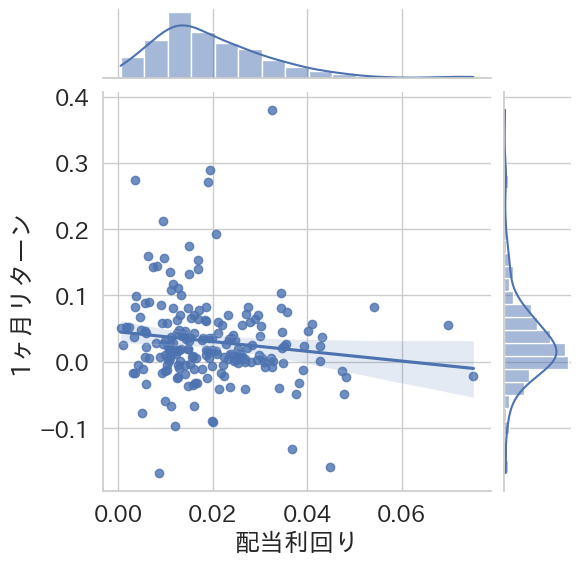

'３ヶ月リターン'

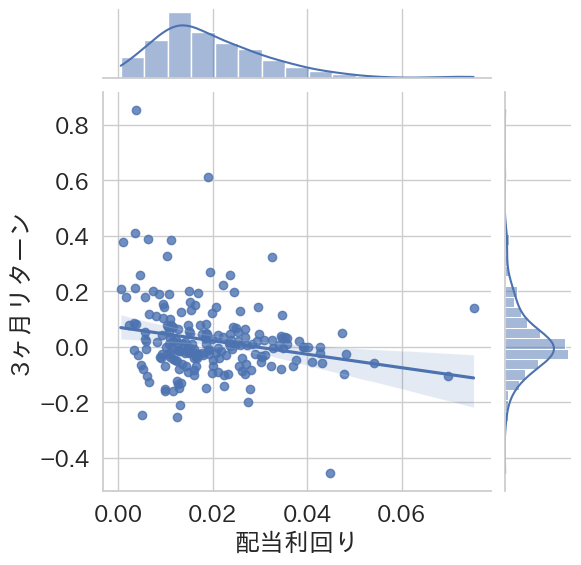

In [20]:
# 横軸に配当利回り、縦軸に1,3ヶ月リターンとして関係性をプロットします
display("1ヶ月リターン")
sns.jointplot(x='配当利回り', y='1ヶ月リターン', data=df_work.loc[df_work["配当利回り"] > 0.00], kind="reg")
plt.show()

display("３ヶ月リターン")
sns.jointplot(x='配当利回り', y='3ヶ月リターン', data=df_work.loc[df_work["配当利回り"] > 0.00], kind="reg")
plt.show()

'1ヶ月リターン'

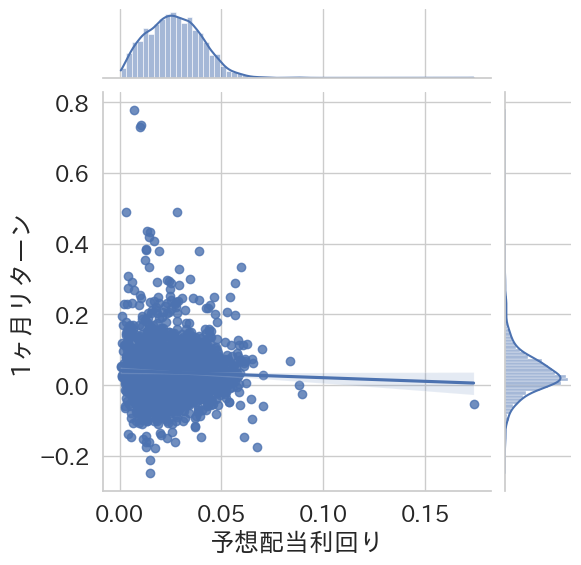

'３ヶ月リターン'

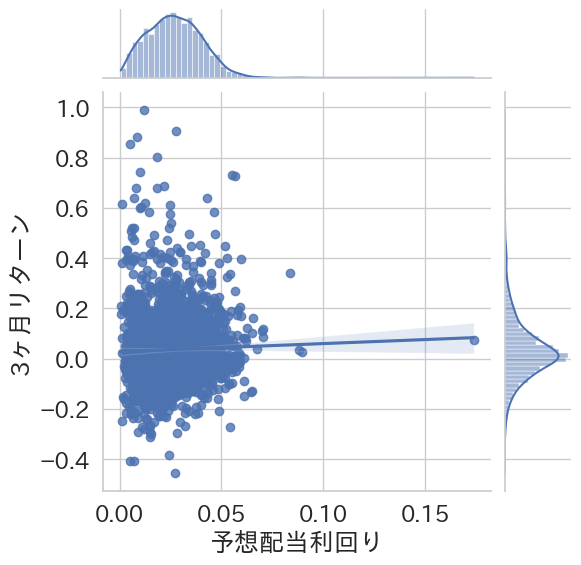

In [21]:
# 横軸に予想配当利回り、縦軸に1,3,6ヶ月リターンとして関係性をプロットします
display("1ヶ月リターン")
sns.jointplot(x='予想配当利回り', y='1ヶ月リターン', data=df_work.loc[df_work["予想配当利回り"] > 0.00], kind="reg")
plt.show()

display("３ヶ月リターン")
sns.jointplot(x='予想配当利回り', y='3ヶ月リターン', data=df_work.loc[df_work["予想配当利回り"] > 0.00], kind="reg")
plt.show()

'1ヶ月リターン'

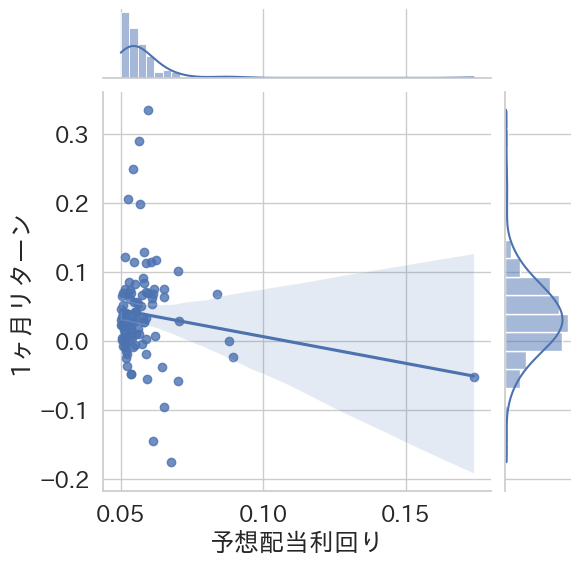

'３ヶ月リターン'

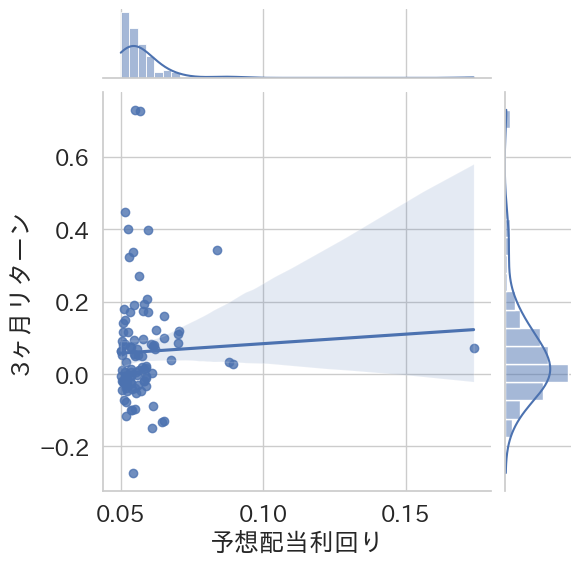

In [22]:
# 予想配当利回りが5%以上の銘柄とリターンの関係性をプロットします
display("1ヶ月リターン")
sns.jointplot(x='予想配当利回り', y='1ヶ月リターン', data=df_work.loc[df_work["予想配当利回り"] >= 0.05], kind="reg")
plt.show()

display("３ヶ月リターン")
sns.jointplot(x='予想配当利回り', y='3ヶ月リターン', data=df_work.loc[df_work["予想配当利回り"] >= 0.05], kind="reg")
plt.show()

## 遊びデータ